In [37]:
import os
import json


def get_relative_path(filename):
    # dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = "/Users/dan/Library/Mobile Documents/com~apple~CloudDocs/_UW_classes/24_FA/cs561/project/_repo/djs/analysis"
    return os.path.join(dir_path, filename)


def load_results(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    return [json.loads(line) for line in lines if line != ""]


## metrics of interest:
# percent zeros
def get_num_zeros(results, tolerance=1e-2):
    return sum(
        1 if result["bleu"] < tolerance else 0 for result in results if "bleu" in result
    )


# percent errors
def get_num_errors(results):
    return sum(1 if "error" in result else 0 for result in results)


def get_error_distro(results):
    return ["error" in result for result in results]


# some kind of plot of the non-zeros
def get_non_zeros(results, tolerance=1e-2):
    return [
        result["bleu"]
        for result in results
        if "bleu" in result and result["bleu"] >= tolerance
    ]


def get_non_errors(results):
    return [result["bleu"] for result in results if "bleu" in result]


# plot of deltas, w/ summary statistics
def get_deltas(baseline_results, manipulation_results, tolerance=1e-4):
    return_val = []
    for baseline_result, manip_result in zip(baseline_results, manipulation_results):
        if "error" in baseline_result or "error" in manip_result:
            return_val.append(None)
            continue

        return_val.append(manip_result["bleu"] - baseline_result["bleu"])
    return return_val

In [8]:
base_results_data = load_results(get_relative_path("_base.jsonl"))
finetune_results_data = load_results(get_relative_path("_finetune.jsonl"))

assert len(base_results_data) == len(finetune_results_data)

n_samples = len(base_results_data)

In [41]:
base_count_zeros = get_num_zeros(base_results_data)
base_percent_zeros = base_count_zeros / n_samples

base_count_errs = get_num_errors(base_results_data)
base_percent_errs = base_count_errs / n_samples

fine_count_zeros = get_num_zeros(finetune_results_data)
fine_percent_zeros = fine_count_zeros / n_samples

fine_count_errs = get_num_errors(finetune_results_data)
fine_percent_errs = fine_count_errs / n_samples

base_errors = get_error_distro(base_results_data)
fine_errors = get_error_distro(finetune_results_data)

base_nonerrors = get_non_errors(base_results_data)
fine_nonerrors = get_non_errors(finetune_results_data)

base_avg = sum(base_nonerrors) / len(base_nonerrors)
fine_avg = sum(fine_nonerrors) / len(fine_nonerrors)

base_nonzeros = get_non_zeros(base_results_data)
fine_nonzeros = get_non_zeros(finetune_results_data)

base_excl0_avg = sum(base_nonzeros) / len(base_nonzeros)
fine_excl0_avg = sum(fine_nonzeros) / len(fine_nonzeros)

In [44]:
print(f"{base_count_errs=}")
print(f"{base_count_zeros=}")
print(f"{fine_count_errs=}")
print(f"{fine_count_zeros=}")
print()
print(f"{base_percent_errs=}")
print(f"{base_percent_zeros=}")
print(f"{fine_percent_errs=}")
print(f"{fine_percent_zeros=}")
print()
print(f"{base_avg=}")
print(f"{fine_avg=}")
print(f"{base_excl0_avg=}")
print(f"{fine_excl0_avg=}")

base_count_errs=41
base_count_zeros=242
fine_count_errs=39
fine_count_zeros=326

base_percent_errs=0.080078125
base_percent_zeros=0.47265625
fine_percent_errs=0.076171875
fine_percent_zeros=0.63671875

base_avg=0.07598978632550947
fine_avg=0.05441158354203413
base_excl0_avg=0.1556684170368236
fine_excl0_avg=0.17394415867928062


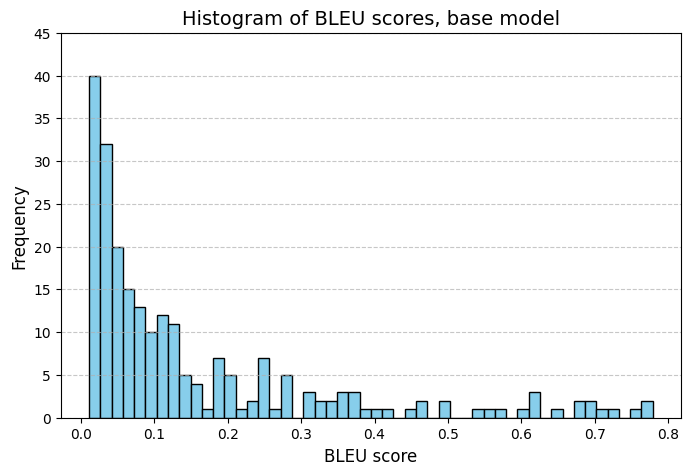

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(base_nonzeros, bins=50, color="skyblue", edgecolor="black")
plt.title("Histogram of BLEU scores, base model", fontsize=14)
plt.xlabel("BLEU score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 45)
plt.show()

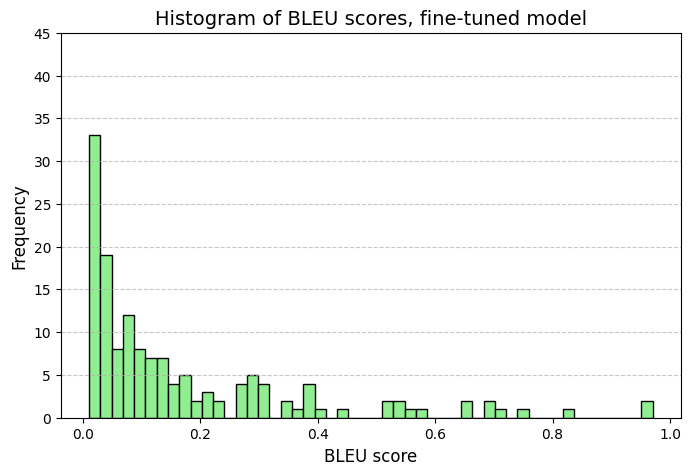

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(fine_nonzeros, bins=50, color="lightgreen", edgecolor="black")
plt.title("Histogram of BLEU scores, fine-tuned model", fontsize=14)
plt.xlabel("BLEU score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 45)
plt.show()

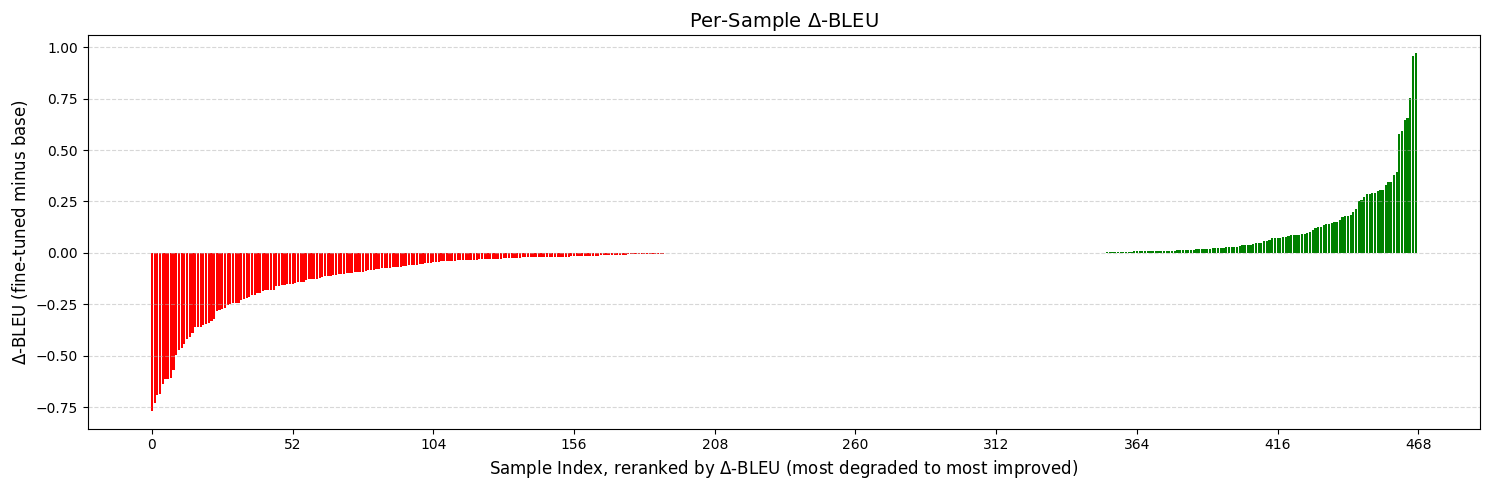

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate differences
# differences = [
#     diff or 0 for diff in get_deltas(base_results_data, finetune_results_data)
# ]
differences = sorted(
    diff
    for diff in get_deltas(base_results_data, finetune_results_data)
    if diff is not None
)


# Set up colors for positive (green) and negative (red) bars
colors = ["green" if diff > 0 else "red" for diff in differences]

# Plot
plt.figure(figsize=(15, 5))
bars = plt.bar(
    range(len(differences)),
    differences,
    color=colors,
)

# Add labels and title
plt.title("Per-Sample $\Delta$-BLEU", fontsize=14)
plt.xlabel(
    "Sample Index, reranked by $\Delta$-BLEU (most degraded to most improved)",
    fontsize=12,
)
plt.ylabel("$\Delta$-BLEU (fine-tuned minus base)", fontsize=12)

# Customize x-axis to make the plot more readable if needed
plt.xticks(ticks=np.linspace(0, len(differences), 10, dtype=int))

# Show plot
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()